# E-Commerce: Visualization Task

## Imports

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

## Setup

### Visualization Setup

In [59]:
%matplotlib inline
sns.set_theme(style="darkgrid", context="notebook", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

### Spark Setup

In [60]:
TABLES: dict[str,str] = {
    "mart.fct_order_item_extended": "fct_order_item_extended",
    "mart.dim_customer": "dim_customer",
    "mart.dim_order_review": "dim_order_review",
    "mart.dim_order": "dim_order",
    "mart.dim_product": "dim_product"
}

In [61]:
spark = SparkSession.builder.getOrCreate()

postgres_reader = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://localhost:5432/warehouse")
    .option("user", "dbt_user")
    .option("password", "kuromi")
    .option("driver", "org.postgresql.Driver")
    .option("spark.sql.repl.eagerEval.enabled", True)
)

**Create Views**

In [62]:
for table_name, view_name in TABLES.items():
    print(f"Creating view `{view_name}` from table `{table_name}`")
    postgres_reader.option("dbtable", table_name).load().createOrReplaceTempView(view_name)

Creating view `fct_order_item_extended` from table `mart.fct_order_item_extended`
Creating view `dim_customer` from table `mart.dim_customer`
Creating view `dim_order_review` from table `mart.dim_order_review`
Creating view `dim_order` from table `mart.dim_order`
Creating view `dim_product` from table `mart.dim_product`


## Visualization

### Q1: What is the average time from purchase to delivery?

In [50]:
days_until_delivery_list = tuple(
    row["days_until_delivery"]
    for row in spark.sql("SELECT days_until_delivery FROM fct_order_item_extended WHERE days_until_delivery IS NOT NULL;").collect()
)

In [51]:
median = np.median(days_until_delivery_list)
median

np.float64(10.0)

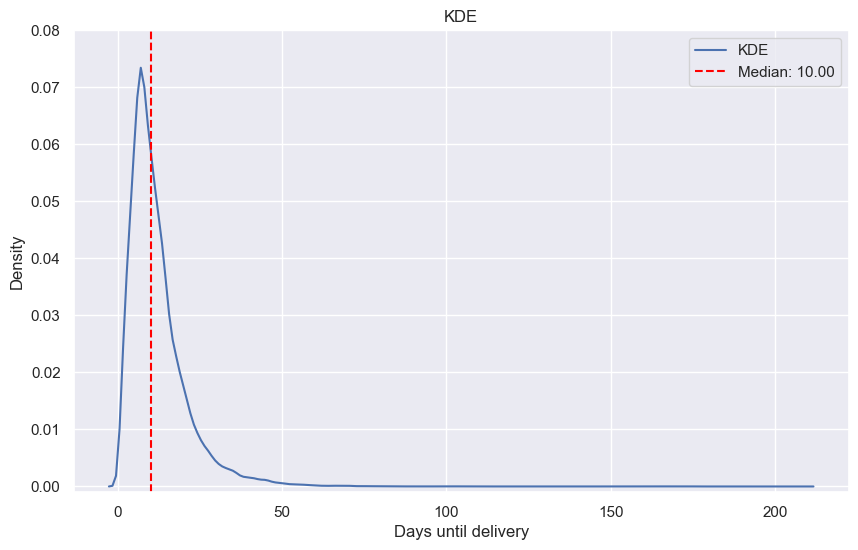

In [48]:
sns.kdeplot(x=days_until_delivery_list, label="KDE")

# Median
plt.axvline(median, color='red', linestyle='--', linewidth=1.5, label=f'Median: {median:.2f}')

# Force y-axis to start a bit below zero (for styling)
plt.ylim(-0.001, None)

yticks = plt.yticks()[0]
yticks = [tick for tick in yticks if tick >= 0]
plt.yticks(yticks)

plt.title("KDE")
plt.xlabel("Days until delivery")
plt.ylabel("Density")
plt.legend()
plt.show()

### Q2: What are the top-performing product categories by revenue?

Considering only the price of products (and not the freight price as it is not clear is this is constant), we look at the individual price of the items in the fact order table and join it to the product dimension table in order to get see its category.

We get the top 10 categories

In [92]:
query_q2 = """
WITH item_product_price_per_category AS
(
    SELECT DISTINCT
        fct_order.product_price,
        product.product_category_name
    FROM fct_order_item_extended AS fct_order
        INNER JOIN dim_product AS product ON
                fct_order.product_id = product.product_id
            AND product.dbt_valid_to IS NULL
),
total_revenue_per_category AS
(
    SELECT
        product_category_name,
        SUM(product_price) AS total_revenue
    FROM item_product_price_per_category
    GROUP BY product_category_name
)
SELECT
    product_category_name,
    total_revenue
FROM total_revenue_per_category
ORDER BY total_revenue DESC
LIMIT 10
;
"""

In [99]:
revenue_per_cat_df = spark.sql(query_q2).toPandas()

In [101]:
revenue_per_cat_df

,product_category_name,total_revenue
0,relogios_presentes,356349.93
1,beleza_saude,258592.82
2,esporte_lazer,221443.01
3,informatica_acessorios,219228.89
4,automotivo,175021.60
5,utilidades_domesticas,161385.86
6,ferramentas_jardim,155387.88
7,cool_stuff,129487.66
8,cama_mesa_banho,126122.15
9,bebes,119100.09


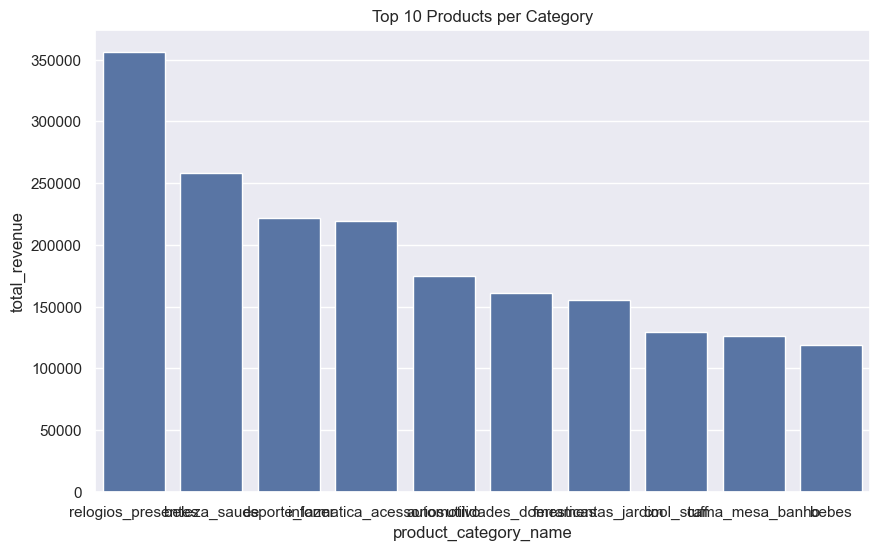

In [104]:
sns.barplot(data=revenue_per_cat_df, x="product_category_name", y="total_revenue")

plt.title("Top 10 Products per Category")
plt.show()

### Q3: How do review scores correlate with delivery time?

Common correlation methods (*e.g.* Spearman, Pearson) are not suited for deriving correlation between a categorical variable and a continuous variable.

An alternative might encoding the the review score as 5 binary fields in order to apply [Point-biserial](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) correlation coefficient.

We use a Violin plot in order to observe the interactions.

In [105]:
query_q3 = """
SELECT
    latest_review_score,
    days_until_delivery
FROM fct_order_item_extended
WHERE days_until_delivery IS NOT NULL
;
"""

In [110]:
review_days_delivery_corr_df = spark.sql(query_q3).toPandas()

/tmp/ipykernel_341930/1926563358.py:1: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


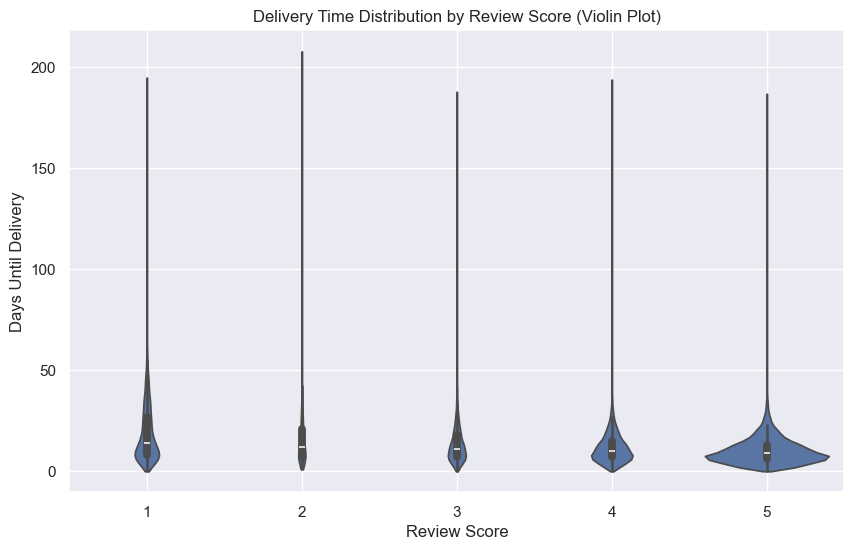

In [117]:
sns.violinplot(
    data=review_days_delivery_corr_df,
    x="latest_review_score",
    y="days_until_delivery",
    order=[1, 2, 3, 4, 5],
    inner="box",
    scale="count",
    cut=0
)

plt.title("Delivery Time Distribution by Review Score (Violin Plot)")
plt.xlabel("Review Score")
plt.ylabel("Days Until Delivery")
plt.grid(True)
plt.show()

From the graph, one could see that the score 5 has a broader distribution, meaning more users with long delivery times still gave high ratings. 

However, narrower violins at low scores distributions are more compact, but still include long-tail deliveries. Users giving scores 1–3 don't seem to have a radically different delivery time, but may be more sensitive to small delays or other service issues.

**Lower review scores do not consistently have longer delivery times**

#### Point-biserial Investigation

In [119]:
point_biserial_query = """
SELECT
    CASE WHEN latest_review_score = 1 THEN 1 ELSE 0 END AS score_encoding_1,
    CASE WHEN latest_review_score = 2 THEN 1 ELSE 0 END AS score_encoding_2,
    CASE WHEN latest_review_score = 3 THEN 1 ELSE 0 END AS score_encoding_3,
    CASE WHEN latest_review_score = 4 THEN 1 ELSE 0 END AS score_encoding_4,
    CASE WHEN latest_review_score = 5 THEN 1 ELSE 0 END AS score_encoding_5,
    days_until_delivery
FROM fct_order_item_extended
WHERE days_until_delivery IS NOT NULL
"""

In [122]:
biserial_df = spark.sql(point_biserial_query).toPandas()
biserial_df

,score_encoding_1,score_encoding_2,score_encoding_3,score_encoding_4,score_encoding_5,days_until_delivery
0,0,0,0,0,1,7
1,0,0,0,1,0,16
2,0,0,0,0,1,7
3,0,0,0,1,0,6
4,0,0,0,0,1,25
...,...,...,...,...,...,...
109886,0,0,0,0,1,17
109887,0,0,0,0,1,9
109888,0,0,0,0,1,4
109889,0,0,0,0,1,1
